In [57]:
import pickle
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter
from itertools import combinations
import community
import pandas as pd
import os
import bz2
import json
from random import sample
import scipy.stats as stats

from collections import defaultdict
from hungarian import Hungarian

In [2]:
filenamevar = 'excl'

In [5]:
networklist = [nx.read_gexf('EoBoR_%i_%s.gexf'%(i,filenamevar)) for i in range(4)]
usersets = [set(x.nodes()) for x in networklist]

In [74]:
[nx.number_of_edges(x) for x in networklist]

[3972, 4228, 1875, 1590]

### Testing Jaccard distance

In [24]:
def jaccardDistro(network1,network2):
    partitions1 = community.best_partition(network1)
    partitions2 = community.best_partition(network2)
    
    cost_matrix = np.ones( (len(set(partitions1.values())),len(set(partitions2.values()))) )
    
    partitions1_transpose = defaultdict(list)
    for k,v in partitions1.items():
        partitions1_transpose[v].append(k)
    partitions1_transpose = dict(partitions1_transpose)
    partitions2_transpose = defaultdict(list)
    for k,v in partitions2.items():
        partitions2_transpose[v].append(k)
    partitions2_transpose = dict(partitions2_transpose)
    
    for thing1 in set(partitions1.values()):
        for thing2 in set(partitions2.values()):
            #1 - jaccard similarity = jaccard distance
            cost_matrix[thing1,thing2] -= float( len(set(partitions1_transpose[thing1])&set(partitions2_transpose[thing2])))/len(set(partitions1_transpose[thing1])|set(partitions2_transpose[thing2]))
    
    hungarian = Hungarian(cost_matrix)
    hungarian.calculate()
    return hungarian

In [38]:
test = jaccardDistro(networklist[2],networklist[1])

In [39]:
test.get_results()

[(2, 6),
 (4, 2),
 (5, 3),
 (6, 7),
 (7, 9),
 (8, 1),
 (11, 13),
 (13, 14),
 (1, 0),
 (14, 11),
 (3, 12),
 (0, 4),
 (9, 5),
 (10, 8),
 (12, 10),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22)]

In [40]:
test.get_total_potential()

20.533403368456383

### Doing trials

In [48]:
def subsample(g,trim_num):
    if len(g)<=trim_num:
        raise ValueError('Subgraph parameters are larger than the original graph.')
    a = g.copy()
    random_nodes = sample(a.nodes(),len(a)-trim_num)
    a.remove_nodes_from(random_nodes)
    return a

def subsetTrials(orig,final,n_trials=100):
    betweenness = []; average_degree = []; diameter = []; avg_shortest_path_len = []; assortativity = []; density = []; average_clustering = []; num_cliques = []; transitivity = []; rich_club = []
    hungar_jaccard = []
    for x in tqdm(range(n_trials)):
        norm_g = subsample(orig,len(final))
        #Betweenness
        #betweenness.append(nx.betweenness_centrality(norm_g,weight='weight'))
        #Average degree
        average_degree.append(np.mean(norm_g.degree().values()))
        #Diameter
        giant = max(nx.connected_component_subgraphs(norm_g), key=len)
        diameter.append(nx.diameter(giant))
        #Average path length
        avg_shortest_path_len.append(nx.average_shortest_path_length(giant,weight='weight'))
        #Degree assortativity
        edge_weights = nx.get_edge_attributes(norm_g,'weight')
        nx.set_edge_attributes( norm_g, 'weight', {key:int(val) for key,val in edge_weights.items()} )
        assortativity.append(nx.degree_assortativity_coefficient(norm_g,weight='weight'))
        density.append(nx.density(norm_g))
        average_clustering.append(nx.average_clustering(norm_g))
        num_cliques.append(nx.graph_number_of_cliques(norm_g))
        transitivity.append(nx.transitivity(norm_g))
        #rich_club.append(nx.rich_club_coefficient(norm_g))
        hungar_jaccard.append(jaccardDistro(orig,norm_g).get_total_potential())
    return average_degree, diameter, avg_shortest_path_len, assortativity, density, average_clustering, num_cliques, transitivity, hungar_jaccard

In [49]:
average_degree, diameter, avg_shortest_path_len, assortativity, density, average_clustering, num_cliques, transitivity, hungar_jaccard = subsetTrials(networklist[1],networklist[2],n_trials=500)

100%|██████████| 500/500 [19:45<00:00,  2.03s/it]


6.91018947368


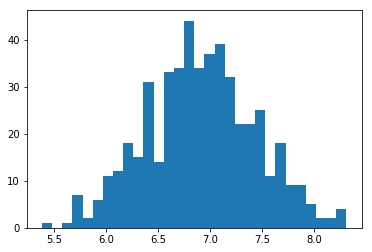

9.012


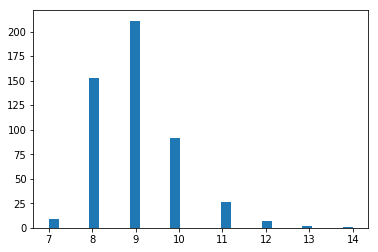

7.56403959752


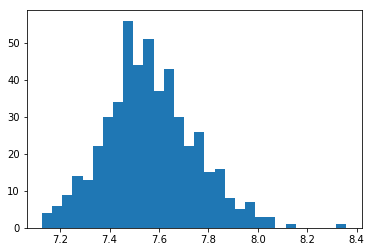

-0.113439292262


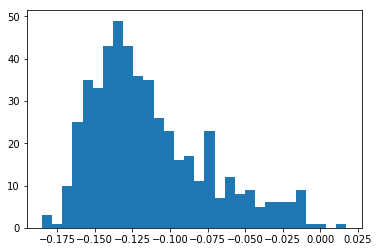

0.0121444454722


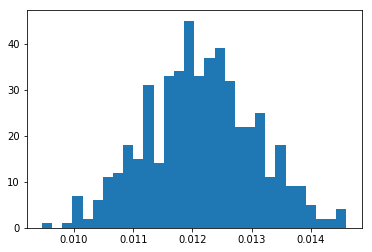

0.258313825412


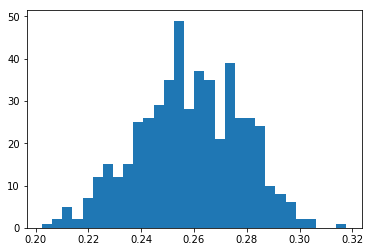

1171.404


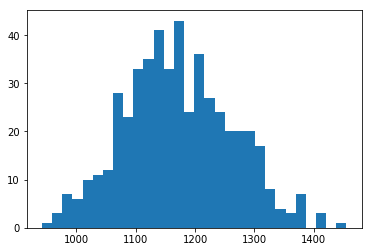

0.238561598111


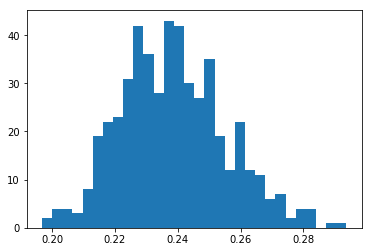

11.0309260155


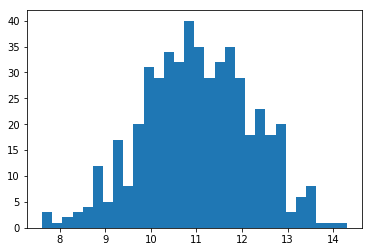

In [50]:
for thing in [average_degree, diameter, avg_shortest_path_len, assortativity, density, average_clustering, num_cliques, transitivity, hungar_jaccard]:
    print np.mean(thing)
    plt.hist(thing,bins=30)
    plt.show()

In [55]:
real_average_degree = np.mean(networklist[2].degree().values())
#Diameter
giant = max(nx.connected_component_subgraphs(networklist[2]), key=len)
real_diameter = nx.diameter(giant)
#Average path length
real_avg_shortest_path_len = nx.average_shortest_path_length(giant,weight='weight')
#Degree assortativity
edge_weights = nx.get_edge_attributes(networklist[2],'weight')
nx.set_edge_attributes( networklist[2], 'weight', {key:int(val) for key,val in edge_weights.items()} )
real_assortativity = nx.degree_assortativity_coefficient(networklist[2],weight='weight')
real_density = nx.density(networklist[2])
real_average_clustering = nx.average_clustering(networklist[2])
real_num_cliques = nx.graph_number_of_cliques(networklist[2])
real_transitivity = nx.transitivity(networklist[2])
real_hungar_jaccard = jaccardDistro(networklist[1],networklist[2]).get_total_potential()

In [69]:
def zscoring(data,val):
    zscore = stats.zscore([val] + data)
    return zscore

def kolmogorovSmirnoving(data,val):
    result = stats.ks_2samp(data, [val])
    return result

def pvaluing(zscore):
    p_values = stats.norm.sf(abs(zscore))*2
    return p_values

In [59]:
null_statistics = [average_degree, diameter, avg_shortest_path_len, assortativity, density, average_clustering, num_cliques, transitivity, hungar_jaccard]
real_values = [real_average_degree,real_diameter,real_avg_shortest_path_len,real_assortativity,real_density,real_average_clustering,real_num_cliques,real_transitivity,real_hungar_jaccard]

| value                 |
|-----------------------|
| average_degree        |
| diameter              |
| avg_shortest_path_len |
| assortativity         |
| density               |
| average_clustering    |
| num_cliques           |
| transitivity          |
| hungar_jaccard        |

In [76]:
real_values

[6.5789473684210522,
 8,
 8.16816883422388,
 0.0046236822924647352,
 0.011562297659790954,
 0.22645141867774762,
 1051,
 0.272801591410742,
 20.533403368456383]

In [77]:
for n,r in zip(null_statistics,real_values):
    print zscoring(n,r)[0]

-0.632213548674
-1.00602187169
3.25598233334
3.00823078154
-0.632213548674
-1.6072436739
-1.32192512511
2.02914338185
7.51184433438


In [64]:
for n,r in zip(null_statistics, real_values):
    print kolmogorovSmirnoving(n,r)

Ks_2sampResult(statistic=0.73799999999999999, pvalue=0.38302390550080939)
Ks_2sampResult(statistic=0.67599999999999993, pvalue=0.49481388711348895)
Ks_2sampResult(statistic=0.998, pvalue=0.098635004684842473)
Ks_2sampResult(statistic=0.998, pvalue=0.098635004684842473)
Ks_2sampResult(statistic=0.73799999999999999, pvalue=0.38302390550080939)
Ks_2sampResult(statistic=0.93199999999999994, pvalue=0.14489874205381176)
Ks_2sampResult(statistic=0.91400000000000003, pvalue=0.16017987031411579)
Ks_2sampResult(statistic=0.97399999999999998, pvalue=0.11379062726590453)
Ks_2sampResult(statistic=1.0, pvalue=0.097451698078349178)


### Now figure out where people diverted to